In [1]:
import numpy as np
import jax.numpy as jnp
import dill
import sys
import os
sys.path.append(os.path.expanduser('~') + '/igm_emulator/igm_emulator/emulator')
from emulator_run import nn_emulator
import matplotlib.pyplot as plt
import h5py
import IPython
sys.path.append(os.path.expanduser('~') + '/igm_emulator/igm_emulator/hmc')
from nn_hmc_3d_x import NN_HMC_X

64


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Layers: [100, 100, 100, 276]
Activation: <PjitFunction of <function leaky_relu at 0x7f3d23311940>>
L2 regularization lambda: 0.0001
meanX = [8.400e-02 9.149e+03 1.352e+00]
stdX = [1.36930639e-02 5.50374022e+03 6.02494813e-01]
train: (768, 3)
(358, 59)
64


/home/zhenyujin/.virtualenvs/igm_emulator/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
true_temp_idx = 11
true_gamma_idx = 4
true_fobs_idx = 7
n_inference = 5

# read in Molly's nearest grid models
zstr = 'z54'
skewers_per_data = 17
n_covar = 500000
bin_label = '_set_bins_4'
in_path_molly = f'/mnt/quasar2/mawolfson/correlation_funct/temp_gamma/final/{zstr}/final_135/'
# get initial grid
in_name_h5py = f'correlation_temp_fluct_skewers_2000_R_30000_nf_9_dict{bin_label}.hdf5'
with h5py.File(in_path_molly + in_name_h5py, 'r') as f:
    params = dict(f['params'].attrs.items())
fobs = params['average_observed_flux']
R_value = params['R']
v_bins = params['v_bins']
t_0s = 10.**params['logT_0']
gammas = params['gamma']
n_temps = len(t_0s)
n_gammas = len(gammas)
n_f = len(fobs)

noise_idx = 0
like_name_0 = f'likelihood_dicts_R_30000_nf_9_T{true_temp_idx}_G{true_gamma_idx}_SNR0_F{true_fobs_idx}_ncovar_500000_P{skewers_per_data}_set_bins_4.p'
like_dict_0 = dill.load(open(in_path_molly + like_name_0, 'rb'))
in_name_new_params = f'new_covariances_dict_R_30000_nf_9_ncovar_{n_covar}_' \
                     f'P{skewers_per_data}{bin_label}_params.p'
new_param_dict = dill.load(open(in_path_molly + in_name_new_params, 'rb'))
new_temps = new_param_dict['new_temps']
new_gammas = new_param_dict['new_gammas']
new_fobs = new_param_dict['new_fobs']
n_new_t = (len(new_temps) - 1)/(len(t_0s) - 1) - 1
n_new_g = (len(new_gammas) - 1)/(len(gammas) - 1) - 1
n_new_f = (len(new_fobs) - 1)/(len(fobs) - 1) - 1
new_models_np = np.empty([len(new_temps), len(new_gammas), len(new_fobs), len(v_bins)])

for old_t_below_idx in range(n_temps - 1):
    print(f'{old_t_below_idx / (n_temps - 1) * 100}%')
    for old_g_below_idx in range(n_gammas - 1):
        for old_f_below_idx in range(n_f - 1):
            fine_dict_in_name = f'new_covariances_dict_R_{int(R_value)}_nf_{n_f}_T{old_t_below_idx}_' \
                                f'G{old_g_below_idx}_SNR0_F{old_f_below_idx}_ncovar_{n_covar}_' \
                                f'P{skewers_per_data}{bin_label}.p'
            fine_dict = dill.load(open(in_path_molly + fine_dict_in_name, 'rb'))
            new_temps_small = fine_dict['new_temps']
            new_gammas_small = fine_dict['new_gammas']
            new_fobs_small = fine_dict['new_fobs']
            new_models_small = fine_dict['new_models']
            new_covariances_small = fine_dict['new_covariances']
            new_log_dets_small = fine_dict['new_log_dets']
            if old_t_below_idx == n_temps - 2:
                added_t_range = n_new_t + 2
            else:
                added_t_range = n_new_t + 1
            if old_g_below_idx == n_gammas - 2:
                added_g_range = n_new_g + 2
            else:
                added_g_range = n_new_g + 1
            if old_f_below_idx == n_f - 2:
                added_f_range = n_new_f + 2
            else:
                added_f_range = n_new_f + 1
            # print(added_f_range)
            for added_t_idx in range(int(added_t_range)):
                for added_g_idx in range(int(added_g_range)):
                    for added_f_idx in range(int(added_f_range)):
                        final_t_idx = int((old_t_below_idx * (n_new_t + 1)) + added_t_idx)
                        final_g_idx = int((old_g_below_idx * (n_new_g + 1)) + added_g_idx)
                        final_f_idx = int((old_f_below_idx * (n_new_f + 1)) + added_f_idx)
                        new_models_np[final_t_idx, final_g_idx, final_f_idx, :] = new_models_small[added_t_idx, added_g_idx, added_f_idx, :]
new_models = jnp.array(new_models_np)

0.0%
7.142857142857142%
14.285714285714285%
21.428571428571427%
28.57142857142857%
35.714285714285715%
42.857142857142854%
50.0%
57.14285714285714%
64.28571428571429%
71.42857142857143%
78.57142857142857%
85.71428571428571%
92.85714285714286%


In [3]:
def return_idx(value, all_values):
    the_min_value = jnp.min(all_values)
    the_range = jnp.max(all_values) - the_min_value
    scaled_value = (value - the_min_value) / the_range * (len(all_values) - 1)
    nearest_idx = int(jnp.round(scaled_value))
    return nearest_idx
def get_molly_model_nearest(theta,
                                  fine_temps=new_temps, fine_gammas=new_gammas, fine_fobs=new_fobs,
                                  fine_models=new_models):
    temp, gamma, ave_f = theta
    temp_idx = return_idx(temp, fine_temps)
    gamma_idx = return_idx(gamma, fine_gammas)
    fobs_idx = return_idx(ave_f, fine_fobs)
    model = fine_models[temp_idx, gamma_idx, fobs_idx, :]
    return model
def log_likelihood_molly
(theta, corr, theta_covariance=like_dict_0['covariance']
                         , true_log_det=like_dict_0['log_determinant']):
    # temp, g, ave_f = theta
    model = get_molly_model_nearest(theta)
    diff = corr - model
    nbins = len(corr)
    log_like = -(jnp.dot(diff, jnp.linalg.solve(theta_covariance, diff)) + true_log_det + nbins * jnp.log(2.0 * jnp.pi)) / 2.0
    return diff.mean(), log_like

run_tag = f'data_nearest_model{bin_label}'
prior_tag = f'one_prior_T{true_temp_idx}_G{true_gamma_idx}_F{true_fobs_idx}'
out_file_tag = f'log_like_on_grid_{int(n_inference)}_{prior_tag}_R_{int(R_value)}_one_covariance'
in_name_inference = f'{zstr}_{run_tag}_{out_file_tag}.hdf5'
print('reading in')
with h5py.File(in_path_molly + in_name_inference, 'r') as f:
    # IPython.embed()
    true_theta = f['true_theta'][:, :]
    temps_grid = f['temps_grid'][:]
    gammas_grid = f['gammas_grid'][:]
    fobs_grid = f['fobs_grid'][:]
    molly_log_likelihood_grid = f['log_likelihood_grid'][:, :, :, :]  # mocks (5), t_0s (57), gammas (33), <F> (33)

reading in


[[1.02475553e-05 9.73116176e-06 9.12833940e-06 ... 3.99630385e-06
  4.00805966e-06 4.02273826e-06]
 [9.73116176e-06 9.26591484e-06 8.71397732e-06 ... 3.76655716e-06
  3.77817019e-06 3.79203362e-06]
 [9.12833940e-06 8.71397732e-06 8.22309904e-06 ... 3.50982976e-06
  3.52118233e-06 3.53448508e-06]
 ...
 [3.99630385e-06 3.76655716e-06 3.50982976e-06 ... 2.60023611e-06
  2.59081415e-06 2.57198828e-06]
 [4.00805966e-06 3.77817019e-06 3.52118233e-06 ... 2.59081415e-06
  2.61042817e-06 2.61090676e-06]
 [4.02273826e-06 3.79203362e-06 3.53448508e-06 ... 2.57198828e-06
  2.61090676e-06 2.63945356e-06]]


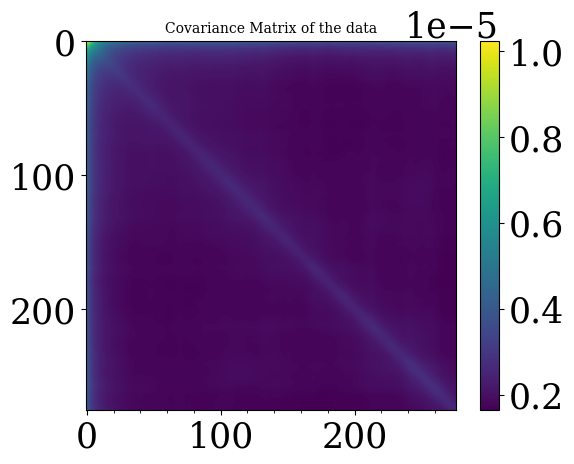

In [4]:
print(like_dict_0['covariance'])
plt.imshow(like_dict_0['covariance'])
plt.title('Covariance Matrix of the data',size =10)
plt.colorbar()

In [5]:
emu_path = os.path.expanduser('~') + f'/igm_emulator/igm_emulator/emulator/best_params/'
with h5py.File(emu_path+'z5.4_nn_savefile.hdf5', 'r') as f:
    # IPython.embed()
    residual = np.asarray(f['performance']['residuals'])
    meanY = np.asarray(f['data']['meanY'])
    stdY = np.asarray(f['data']['stdY'])
    print(f['data'].keys())
    

dir_lhs = os.path.expanduser('~') + '/igm_emulator/igm_emulator/emulator/GRID/'

test_num = '_test_89'
Y_test = dill.load(open(dir_lhs + f'{zstr}_model{test_num}.p', 'rb'))
X_test = dill.load(open(dir_lhs + f'{zstr}_param{test_num}.p', 'rb'))
#Y_test = (Y_test - meanY) / stdY

diff = residual * Y_test
chi2 = []
chi2_molly = []
print(diff.shape)
for d_i, d in enumerate(diff):
    chi2.append(jnp.dot(d, jnp.linalg.solve(like_dict_0['covariance'], d))) 
    diff_molly = get_molly_model_nearest(X_test[d_i,:]) - Y_test[d_i,:]
    chi2_molly.append(jnp.dot(diff_molly, jnp.linalg.solve(like_dict_0['covariance'], diff_molly)))
chi2 = np.array(chi2)
chi2_molly = np.array(chi2_molly)
chi2_dof = chi2/Y_test.shape[1]
chi2_molly_dof = chi2_molly/Y_test.shape[1]
print(Y_test.shape[1])

<KeysViewHDF5 ['meanX', 'meanY', 'stdX', 'stdY', 'test_data', 'train_data', 'vali_data']>
(89, 276)
276


Text(0.5, 1.0, '%Residual plot:mean: 0.000; std: 0.000')

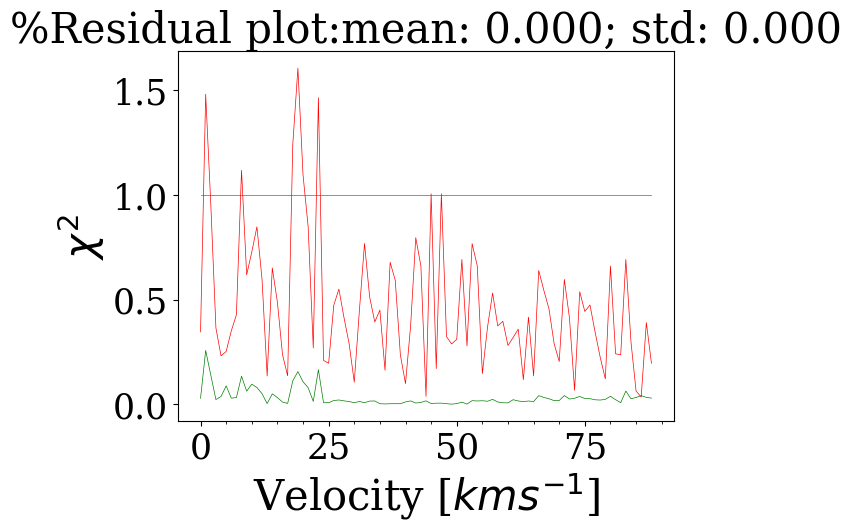

In [6]:
plt.figure()

#plt.plot(np.arange(len(chi2)), chi2, linewidth=0.5)
plt.plot(np.arange(len(chi2)), np.ones_like(chi2), linewidth=0.5)
plt.plot(np.arange(len(chi2)), chi2_dof, linewidth=0.5, color = 'g')
plt.plot(np.arange(len(chi2)), chi2_molly_dof, linewidth=0.5, color = 'r')
#plt.plot(v_bins, np.ones_like(v_bins), c='r',linewidth=0.7)

#plt.plot(v_bins, -np.ones_like(v_bins), c='r',linewidth=0.7)
plt.xlabel(r'Velocity [$km s^{-1}$]')
plt.ylabel(r'$\chi^2$')
plt.title(f'%Residual plot:mean: {np.mean(diff):.3f}; std: {np.std(diff):.3f}')

plt.figure(figsize=(15, 15))
for i in range(diff.shape[0]):
    plt.plot(v_bins[200:], diff[i, 200:] * 100, linewidth=0.5)
plt.plot(v_bins[200:], np.ones_like(v_bins[200:]), c='r',linewidth=0.7)
plt.plot(v_bins[200:], -np.ones_like(v_bins[200:]), c='r',linewidth=0.7)
plt.xlabel(r'Velocity [$km s^{-1}$]')
plt.ylabel(r'$\chi^2$')
plt.title(f'%Residual plot:mean: {np.mean(diff):.3f}; std: {np.std(diff):.3f}')

In [1]:
# get Linda's model
sys.path.append(os.path.expanduser('~') + '/igm_emulator/igm_emulator/hmc')
from nn_hmc_3d_x import NN_HMC_X

in_path_linda = '/mnt/quasar2/zhenyujin/igm_emulator/emulator/best_params/'
emu_name = f'{zstr}_best_param_training_768.p'
best_params = dill.load(open(in_path_linda + emu_name, 'rb'))
nn_x = NN_HMC_X(v_bins, best_params, t_0s, gammas, fobs, like_dict_0)
linda_loglike_grid = dill.load(open(f'linda_loglike_grid_{emu_name}.p', 'rb'))

def get_linda_model(theta, best_params_function=best_params):
    theta_linda = (theta[2], theta[0], theta[1])
    model = nn_emulator(best_params_function, theta_linda)
    return model

def log_likelihood(theta, corr):
        '''
        Args:
            x: dimensionless parameters
            flux: observed flux
        Returns:
            log_likelihood: log likelihood
        '''
        model = get_linda_model(theta) #theta is in physical dimension for this function
        #model = get_molly_model_nearest(theta) #replace same model

        new_covariance = nn_x.like_dict['covariance']
        log_determinant = nn_x.like_dict['log_determinant']

        diff = corr - model
        nbins = len(nn_x.vbins)
        log_like = -(jnp.dot(diff, jnp.linalg.solve(new_covariance, diff)) + log_determinant + nbins * jnp.log(
            2.0 * jnp.pi)) / 2.0
        #print(f'Log_likelihood={log_like}')
        return diff.mean(), log_like

def log_likelihood_linda(theta, corr):
    theta = np.array(theta)
    theta_linda = (theta[2], theta[0], theta[1])
    theta_linda_x = nn_x.theta_to_x(theta_linda)
    diff, ll_linda = nn_x.log_likelihood(theta_linda_x, corr)
    return nn_x.log_likelihood(theta_linda_x, corr)

# read in the mock data
mock_name = f'mocks_R_{int(R_value)}_nf_{n_f}_T{true_temp_idx}_G{true_gamma_idx}_SNR{noise_idx}_F{true_fobs_idx}_P{skewers_per_data}{bin_label}.p'
mocks = dill.load(open(in_path_molly + mock_name, 'rb'))

NameError: name 'sys' is not defined

In [9]:
print(like_dict_0['covariance'],like_dict_0['log_determinant'])
print(best_params['custom_linear/~/linear_3']['b'].shape
     )

[[1.02475553e-05 9.73116176e-06 9.12833940e-06 ... 3.99630385e-06
  4.00805966e-06 4.02273826e-06]
 [9.73116176e-06 9.26591484e-06 8.71397732e-06 ... 3.76655716e-06
  3.77817019e-06 3.79203362e-06]
 [9.12833940e-06 8.71397732e-06 8.22309904e-06 ... 3.50982976e-06
  3.52118233e-06 3.53448508e-06]
 ...
 [3.99630385e-06 3.76655716e-06 3.50982976e-06 ... 2.60023611e-06
  2.59081415e-06 2.57198828e-06]
 [4.00805966e-06 3.77817019e-06 3.52118233e-06 ... 2.59081415e-06
  2.61042817e-06 2.61090676e-06]
 [4.02273826e-06 3.79203362e-06 3.53448508e-06 ... 2.57198828e-06
  2.61090676e-06 2.63945356e-06]] -5113.026959073321
(276,)


In [10]:
print(linda_loglike_grid.shape)

(5, 33, 57, 33)


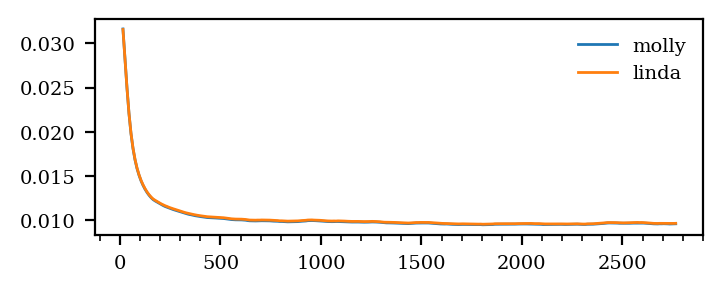

In [11]:
x_size = 3.5
dpi_value = 200
plt_params = {'legend.fontsize': 7,
              'legend.frameon': False,
              'axes.labelsize': 8,
              'axes.titlesize': 6.5,
              'figure.titlesize': 8,
              'xtick.labelsize': 7,
              'ytick.labelsize': 7,
              'lines.linewidth': 1,
              'lines.markersize': 2,
              'errorbar.capsize': 3,
              'font.family': 'serif',
              # 'text.usetex': True,
              'xtick.minor.visible': True,
              }
plt.rcParams.update(plt_params)
# plot one example of model comparison
temperature_want = 10000.
theta_want = (temperature_want, gammas[true_gamma_idx], fobs[true_fobs_idx])
model_molly = get_molly_model_nearest(theta_want)
model_linda = get_linda_model(theta_want)

model_fig = plt.figure(figsize=(x_size, x_size*.77*.5), constrained_layout=True,
                                dpi=dpi_value,
                                )
# one_correlation_fig.set_constrained_layout_pads(w_pad=0, h_pad=0, hspace=0, wspace=0)
grid = model_fig.add_gridspec(
    nrows=1, ncols=1, # width_ratios=[20, 20, 20, 20, 20, 1],
)
axes = model_fig.add_subplot(grid[0])
axes.plot(v_bins, model_molly, label='molly')
axes.plot(v_bins, model_linda, label='linda')
axes.legend()
plt.show()

In [12]:
sys.path.append(os.path.expanduser('~') + '/igm_emulator/igm_emulator/scripts')
from grab_models import *

n_samples = 100
samples = lhs(3, samples=n_samples)

final_samples = np.empty([n_samples, 3])
for sample_idx, sample in enumerate(samples):
    # convert the output of lhs (between 0 and 1 for each parameter) to our model grid
    sample_params = param_transform(sample,
                                    np.array([temps_grid[0], gammas_grid[0], fobs_grid[0]]),
                                    np.array([temps_grid[-1], gammas_grid[-1], fobs_grid[-1]]))
    final_samples[sample_idx, :] = sample_params

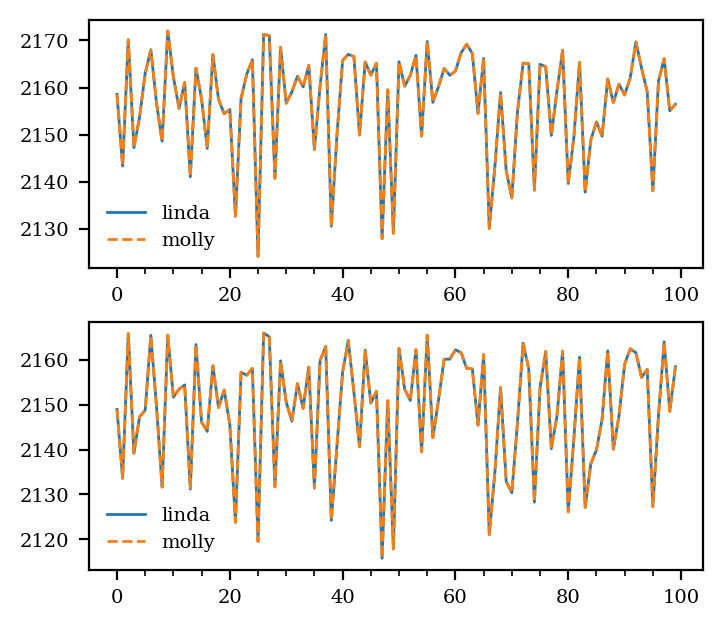

In [13]:
likelihood_fig = plt.figure(figsize=(x_size, x_size*.77*5.*.5), constrained_layout=True,
                                dpi=dpi_value,
                                )
# one_correlation_fig.set_constrained_layout_pads(w_pad=0, h_pad=0, hspace=0, wspace=0)
grid = likelihood_fig.add_gridspec(
    nrows=5, ncols=1, # width_ratios=[20, 20, 20, 20, 20, 1],
)   
for mock_idx in range(2):
    axes = likelihood_fig.add_subplot(grid[mock_idx])
    linda = np.empty(n_samples)
    molly = np.empty(n_samples)
    for sample_idx, sample in enumerate(final_samples):
        linda[sample_idx] = log_likelihood(sample,mocks[mock_idx])[1]
        molly[sample_idx] = log_likelihood_molly(sample,mocks[mock_idx])[1]
        
    axes.plot(np.arange(n_samples),linda,label ='linda')#blue
    axes.plot(np.arange(n_samples),molly, '--', label = 'molly')#orange
    axes.legend()

[2148.99611992 2133.61751395 2165.90418169 2139.19941468 2147.32598018
 2148.80896906 2165.53355081 2149.73605984 2131.65118828 2165.56104277
 2151.72113522 2153.50476948 2154.46070411 2131.19131861 2163.46770166
 2146.12140109 2144.08118055 2158.72318785 2149.41394833 2153.30376855
 2145.65923198 2123.78631566 2157.28050596 2156.61853848 2158.13424791
 2119.5089833  2166.05361101 2165.17654116 2131.69797323 2159.83064291
 2150.6081848  2146.359439   2154.72852313 2149.21172588 2158.44297501
 2131.43263729 2159.83882    2163.04072068 2124.20055257 2140.96449432
 2157.29856519 2164.39450774 2152.87092915 2140.63623488 2162.19651827
 2150.40804134 2153.01072663 2115.74918838 2150.92003512 2117.85054386
 2162.59865895 2153.51885502 2150.98293028 2162.32357566 2139.50311659
 2165.57053628 2142.67790805 2151.0797607  2160.18765641 2160.21040766
 2162.28774289 2161.6758103  2158.1554956  2158.01657008 2145.4530173
 2161.20858734 2121.0404933  2135.03488279 2153.86969425 2132.92885263
 2130.3

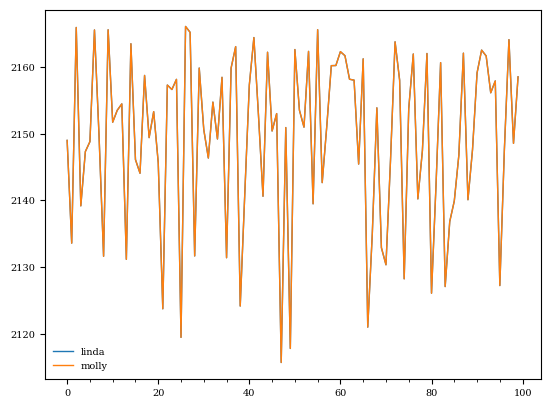

In [14]:
print(linda,molly)
plt.plot(np.arange(n_samples),linda,label ='linda')#blue
plt.plot(np.arange(n_samples),molly, label = 'molly')#orange
plt.legend()
plt.show()

In [33]:
molly_name = f'z54_data_nearest_model_set_bins_4_steps_48000_mcmc_inference_5_one_prior_T{true_temp_idx}_G{true_gamma_idx}_F{true_fobs_idx}_R_30000.hdf5'
molly_model = h5py.File(in_path_molly + molly_name, 'r')


molly_sample = molly_model['samples'][0, :, :]
molly_flip = np.zeros(shape=molly_sample.shape)
molly_flip[:, 0] = molly_sample[:, 2]
molly_flip[:, 1] = molly_sample[:, 0]
molly_flip[:, 2] = molly_sample[:, 1]

t_molly, g_molly, f_molly = map(lambda v: (v[1], v[2] - v[1], v[1] - v[0]),
                                zip(*np.percentile(molly_sample, [16, 50, 84], axis=0)))

print(log_likelihood_molly(theta=[t_molly[0], g_molly[0], f_molly[0]],corr= mocks[0]))
print(log_likelihood(theta=[1.22029536e+04, 1.50778254e+00, 9.96930682e-02],corr= mocks[0]))
#print(log_likelihood(theta=[t_molly[0], g_molly[0], f_molly[0]],corr= mocks[0]))

(Array(0.00020737, dtype=float64), Array(2172.40209913, dtype=float64))
(Array(-0.00037135, dtype=float64), Array(2171.12543565, dtype=float64))


In [41]:
# plot one 1d slice of likelihood - temps only
g_plot_idx = 5 #int(np.floor(len(gammas_grid)/2.))
f_plot_idx = 5 #int(np.floor(len(fobs_grid)/2.))
print(g_plot_idx,f_plot_idx)

molly_log_likelihood_line=np.empty([n_inference,len(temps_grid)])
lina_log_likelihood_line=np.empty([n_inference,len(temps_grid)])

for mock_idx in range(n_inference):
    for i,temp in enumerate(temps_grid):
        molly_log_likelihood_line[mock_idx,i] = log_likelihood_molly([temp, gammas_grid[g_plot_idx],fobs_grid[f_plot_idx]],mocks[mock_idx])[1]
        lina_log_likelihood_line[mock_idx,i] = log_likelihood([temp, gammas_grid[g_plot_idx],fobs_grid[f_plot_idx]],mocks[mock_idx])[1]

5 5


16 16


Text(0.5, 0, '$T_0$ (K)')

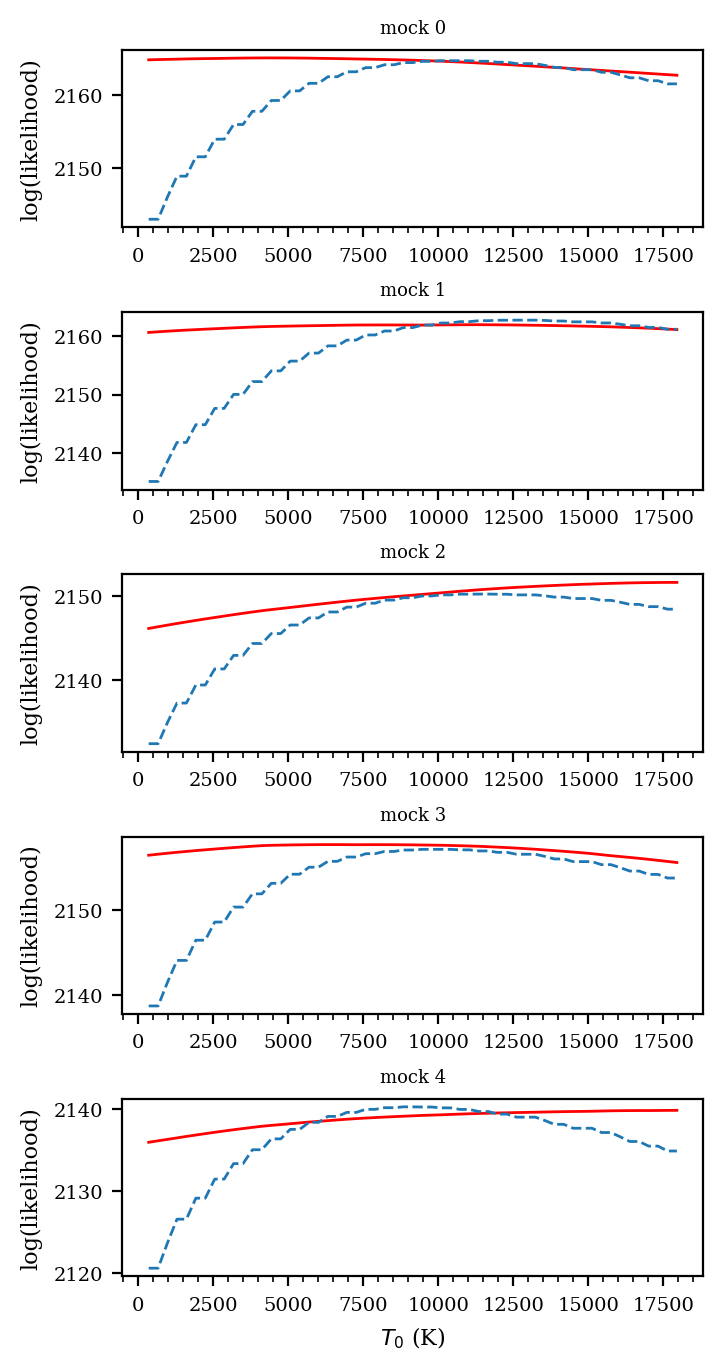

In [42]:
# plot one 1d slice of likelihood - temps only
g_plot_idx = int(np.floor(len(gammas_grid)/2.))
f_plot_idx = int(np.floor(len(fobs_grid)/2.))
print(g_plot_idx,f_plot_idx)
# IPython.embed()
likelihood_fig = plt.figure(figsize=(x_size, x_size*.77*5.*.5), constrained_layout=True,
                                dpi=dpi_value,
                                )
# one_correlation_fig.set_constrained_layout_pads(w_pad=0, h_pad=0, hspace=0, wspace=0)
grid = likelihood_fig.add_gridspec(
    nrows=5, ncols=1, # width_ratios=[20, 20, 20, 20, 20, 1],
)
for mock_idx in range(n_inference):
    axes = likelihood_fig.add_subplot(grid[mock_idx])
    axes.plot(temps_grid, lina_log_likelihood_line[mock_idx,:],'r')
    axes.plot(temps_grid, molly_log_likelihood_line[mock_idx,:],'--')
    axes.set_ylabel('log(likelihood)')
    axes.set_title(f'mock {mock_idx}')
axes.set_xlabel('$T_0$ (K)')